### 2x Better than Chance within trial but does not generalize well accross trials

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import models, transforms
import torch.nn.functional as F
from BcomMEG import *
from MEGDataset_Conv import *
from ConvNet import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [2]:
# So one option would be to use ResNet as the pretrained and try to fine-tune it. 
# I'm not opposed to this, but it would require messing with the first layer, and
# making sort of arbitrary downscaling of the MEG data. We would have to be clever
# about this. I think I'm just going to try to train my own for right now and see
# how it goes
# resnet = models.resnet50(weights='ResNet50_Weights.DEFAULT')
# print(resnet.conv1)

In [4]:
dir = '/Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_ANALYZED/EVOKED/DATA/WITHOUT_BADS/COVERT'
dir1 = '/Users/ciprianbangu/Cogmaster/M2 Internship/BCI code/Data_Sample'
subjects = ['BCOM_18_2']
picks = None

data = BcomMEG(dir=dir, subjects=subjects, picks=picks, avoid_reading=True)

In [4]:
data.upscale(13)

In [5]:
dataset = MEGDataset_Conv(data, label_map='multi_class_covert')

In [22]:
dataset_size = len(dataset)
indices = list(range(dataset_size))
train_indices, test_indices = train_test_split(
    list(range(len(dataset))), 
    test_size=0.4, 
    random_state=42, 
    stratify=dataset.labels)

train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
for batch_index, (data, labels) in enumerate(train_loader):
    print(f"Batch {batch_index}:")
    print(f"  Data shape: {data.shape}")
    print(f"  Labels shape: {labels.shape}")
    break

Batch 0:
  Data shape: torch.Size([4, 1, 247, 241])
  Labels shape: torch.Size([4])


In [23]:
device = 'mps'
model = ConvNet().to(device=device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
epochs = 10

n_total_steps = len(train_loader)

loss_values = []
for epoch in range(epochs):
    for i, (data, labels) in enumerate(train_loader):
        labels = labels.to(device)
        # print(data)

        outputs = model(data)
        # print(f"Outputs: {outputs}")
        # print(f"Labels: {labels}")
        loss = criterion(outputs, labels)
        # print(f"Loss: {loss.item()}")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_values.append(loss.item())

        if (i+1) % 10 == 0:  # Adjusted the condition to a smaller number
            print(f'Epoch [{epoch + 1} / {epochs}], Step [{i + 1}/{n_total_steps}], Loss: {loss.item():.4f}')
print('Training Finished')



Epoch [1 / 10], Step [10/31], Loss: 9.1708
Epoch [1 / 10], Step [20/31], Loss: 3.0337
Epoch [1 / 10], Step [30/31], Loss: 2.8899
Epoch [2 / 10], Step [10/31], Loss: 2.8610
Epoch [2 / 10], Step [20/31], Loss: 2.9205
Epoch [2 / 10], Step [30/31], Loss: 2.8394
Epoch [3 / 10], Step [10/31], Loss: 2.8073
Epoch [3 / 10], Step [20/31], Loss: 2.6034
Epoch [3 / 10], Step [30/31], Loss: 2.3858
Epoch [4 / 10], Step [10/31], Loss: 2.2282
Epoch [4 / 10], Step [20/31], Loss: 1.6561
Epoch [4 / 10], Step [30/31], Loss: 2.4278
Epoch [5 / 10], Step [10/31], Loss: 0.6494
Epoch [5 / 10], Step [20/31], Loss: 0.1801
Epoch [5 / 10], Step [30/31], Loss: 0.2328
Epoch [6 / 10], Step [10/31], Loss: 0.0791
Epoch [6 / 10], Step [20/31], Loss: 0.0413
Epoch [6 / 10], Step [30/31], Loss: 0.0056
Epoch [7 / 10], Step [10/31], Loss: 0.0166
Epoch [7 / 10], Step [20/31], Loss: 0.0376
Epoch [7 / 10], Step [30/31], Loss: 0.1085
Epoch [8 / 10], Step [10/31], Loss: 0.0259
Epoch [8 / 10], Step [20/31], Loss: 0.0929
Epoch [8 / 

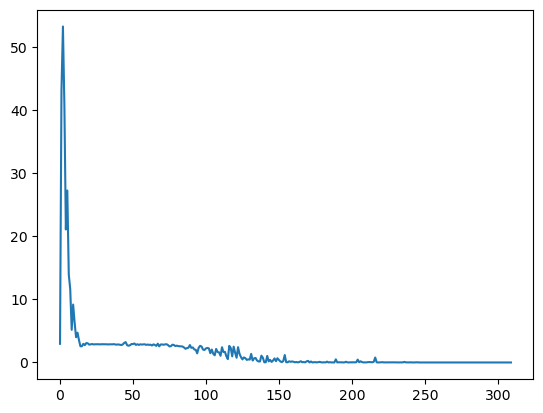

In [24]:
plt.plot(range(len(loss_values)), loss_values)

In [ ]:
test_loss_values = []  # To store test loss
test_accuracies = [] 
all_preds = []
all_labels = []
model.eval()  # Set the model to evaluation mode
test_loss = 0
correct = 0
total = 0
with torch.no_grad():  # Disable gradient computation for evaluation
    for data, labels in test_loader:
        labels = labels.to(device)

        outputs = model(data)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)  # Get class with max logit
        all_preds.extend(predicted.cpu().numpy())  # Collect predictions
        all_labels.extend(labels.cpu().numpy()) 
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

test_loss /= len(test_loader)  # Average test loss
accuracy = correct / total  # Test accuracy
test_loss_values.append(test_loss)
test_accuracies.append(accuracy)

print(f'Epoch [{epoch + 1}/{epochs}], Test Loss: {test_loss:.4f}, Test Accuracy: {100 * accuracy:.4f}')
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"Test Loss: {test_loss:.4f}, F1-Score: {f1:.4f}")

Epoch [10/10], Test Loss: 4.8077, Test Accuracy: 10.8434
Test Loss: 0.0579, F1-Score: 0.1098


In [52]:
1/len(np.unique(dataset.labels)) * 100

5.555555555555555

Then the obvious extension is to train it on more data. Perhaps train it on first 2 trials and have it predict on the last one?

### Accross trials

In [ ]:
data2 = BcomMEG(subjects=['BCOM_18_3', 'BCOM_18_4'], dir=dir, picks=picks, avoid_reading=True)
data2.upscale(13)
tensor_2 = MEGDataset_Conv(data2, label_map='multi_class_covert')
train_loader_2 = DataLoader(tensor_2, batch_size=4, shuffle=True)

In [ ]:
data_test = BcomMEG(subjects=['BCOM_18_2'], dir=dir, picks=picks, avoid_reading=True)
data_test.upscale(13)
tensor_test = MEGDataset_Conv(data_test, label_map='multi_class_covert')
test_loader = DataLoader(tensor_test, batch_size=4, shuffle=False)

In [ ]:
device = 'mps'
model_2 = ConvNet().to(device=device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_2.parameters(), lr=0.00065)
epochs = 8

n_total_steps = len(train_loader_2)

loss_values = []
for epoch in range(epochs):
    for i, (data, labels) in enumerate(train_loader_2):
        labels = labels.to(device)
        # print(data)

        outputs = model_2(data)
        # print(f"Outputs: {outputs}")
        # print(f"Labels: {labels}")
        loss = criterion(outputs, labels)
        # print(f"Loss: {loss.item()}")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_values.append(loss.item())

        if (i+1) % 10 == 0:  # Adjusted the condition to a smaller number
            print(f'Epoch [{epoch + 1} / {epochs}], Step [{i + 1}/{n_total_steps}], Loss: {loss.item():.4f}')
print('Training Finished')


Epoch [1 / 8], Step [10/99], Loss: 3.6860
Epoch [1 / 8], Step [20/99], Loss: 2.8909
Epoch [1 / 8], Step [30/99], Loss: 2.9110
Epoch [1 / 8], Step [40/99], Loss: 2.8782
Epoch [1 / 8], Step [50/99], Loss: 2.9124
Epoch [1 / 8], Step [60/99], Loss: 2.8765
Epoch [1 / 8], Step [70/99], Loss: 2.8844
Epoch [1 / 8], Step [80/99], Loss: 2.8872
Epoch [1 / 8], Step [90/99], Loss: 2.8688
Epoch [2 / 8], Step [10/99], Loss: 2.8884
Epoch [2 / 8], Step [20/99], Loss: 2.8872
Epoch [2 / 8], Step [30/99], Loss: 2.8496
Epoch [2 / 8], Step [40/99], Loss: 2.8825
Epoch [2 / 8], Step [50/99], Loss: 2.8732
Epoch [2 / 8], Step [60/99], Loss: 2.8509
Epoch [2 / 8], Step [70/99], Loss: 3.1566
Epoch [2 / 8], Step [80/99], Loss: 2.9381
Epoch [2 / 8], Step [90/99], Loss: 2.8827
Epoch [3 / 8], Step [10/99], Loss: 2.8913
Epoch [3 / 8], Step [20/99], Loss: 2.8455
Epoch [3 / 8], Step [30/99], Loss: 2.8396
Epoch [3 / 8], Step [40/99], Loss: 2.9086
Epoch [3 / 8], Step [50/99], Loss: 2.8505
Epoch [3 / 8], Step [60/99], Loss:

In [74]:
test_loss_values = []
test_accuracies = [] 
all_preds = []
all_labels = []
model_2.eval()

test_loss = 0
correct = 0
total = 0

with torch.no_grad():
    for data, labels in test_loader:
        # Move both data and labels to device
        labels = labels.to(device)
        
        # Get predictions
        outputs = model_2(data)
        loss = criterion(outputs, labels)
        
        # Accumulate loss
        test_loss += loss.item()
        
        # Get predictions
        _, predicted = torch.max(outputs.data, 1)
        
        # Save predictions and labels for metrics
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        # Calculate accuracy
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    # Calculate final metrics
    test_loss /= len(test_loader)
    accuracy = correct / total

    print(f'Test Loss: {test_loss:.4f}, Accuracy: {100 * accuracy:.2f}%')

# Print detailed metrics
from sklearn.metrics import classification_report, confusion_matrix
print("\nConfusion Matrix:")
print(confusion_matrix(all_labels, all_preds))
print("\nDetailed Classification Report:")
print(classification_report(all_labels, all_preds))

# Additional diagnostics
print("\nClass distribution in test set:")
from collections import Counter
print(Counter(all_labels))

# Look at some predictions
print("\nSample predictions vs actual:")
for i in range(min(10, len(all_preds))):
    print(f"Predicted: {all_preds[i]}, Actual: {all_labels[i]}")

Test Loss: 7.5752, Accuracy: 2.91%

Confusion Matrix:
[[1 0 1 1 0 0 2 2 1 1 1 2 0 0 0 2 0 2]
 [1 0 1 0 0 0 0 1 2 2 1 2 0 0 1 1 0 0]
 [0 0 1 1 0 1 0 2 2 0 1 2 0 0 0 0 0 2]
 [1 1 1 0 0 2 0 1 3 1 0 2 1 0 1 0 0 2]
 [0 2 1 0 0 1 0 0 0 0 0 0 0 0 0 3 0 0]
 [0 1 2 4 0 0 1 0 1 0 0 1 1 1 0 1 0 1]
 [1 0 1 1 0 2 0 0 3 1 1 1 0 1 2 2 1 1]
 [1 0 1 0 0 2 0 0 1 0 0 3 1 0 0 1 1 1]
 [1 0 0 1 0 1 0 0 1 0 1 2 0 0 0 1 1 2]
 [0 0 1 1 0 0 1 1 2 0 1 0 1 1 1 2 1 1]
 [1 0 0 0 0 0 0 0 0 0 0 4 0 0 1 1 1 0]
 [0 0 0 0 0 2 2 1 3 0 2 1 0 0 0 0 1 1]
 [1 1 0 0 0 0 0 2 2 1 2 2 0 0 0 0 0 2]
 [0 0 0 1 0 2 0 0 1 0 0 0 0 0 0 0 1 0]
 [0 0 1 1 0 0 1 0 1 0 0 1 0 0 0 1 0 0]
 [0 0 1 0 0 2 0 0 2 0 2 0 0 0 1 2 3 0]
 [2 0 0 1 0 0 1 2 1 1 0 0 0 0 0 1 0 1]
 [0 1 0 0 0 0 0 0 2 0 0 1 0 0 1 1 0 0]]

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.10      0.06      0.08        16
           1       0.00      0.00      0.00        12
           2       0.08      0.08      0.08    

/opt/homebrew/Caskroom/miniconda/base/envs/mne/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/mne/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/mne/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

### Let's keep it within trials

In [167]:
dataset_3_size = len(tensor_2)
indices = list(range(dataset_3_size))
train_indices, test_indices = train_test_split(
    list(range(len(tensor_2))), 
    test_size=0.40, 
    random_state=42, 
    stratify=tensor_2.labels)

train_dataset_3 = Subset(tensor_2, train_indices)
test_dataset_3 = Subset(tensor_2, test_indices)

train_loader_3 = DataLoader(train_dataset_3, batch_size=10, shuffle=True)
test_loader_3 = DataLoader(test_dataset_3, batch_size=1, shuffle=False)

In [112]:
train_loader_3

In [180]:
device = 'mps'
model_3 = ConvNet().to(device=device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_3.parameters(), lr=0.00065)
epochs = 20

n_total_steps = len(train_loader_3)

loss_values = []
for epoch in range(epochs):
    for i, (data, labels) in enumerate(train_loader_3):
        labels = labels.to(device)
        # print(data)

        outputs = model_3(data)
        # print(f"Outputs: {outputs}")
        # print(f"Labels: {labels}")
        loss = criterion(outputs, labels)
        # print(f"Loss: {loss.item()}")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_values.append(loss.item())

        if (i+1) % 10 == 0:  # Adjusted the condition to a smaller number
            print(f'Epoch [{epoch + 1} / {epochs}], Step [{i + 1}/{n_total_steps}], Loss: {loss.item():.4f}')
print('Training Finished')


Epoch [1 / 20], Step [10/24], Loss: 4.7987
Epoch [1 / 20], Step [20/24], Loss: 2.9143
Epoch [2 / 20], Step [10/24], Loss: 2.9732
Epoch [2 / 20], Step [20/24], Loss: 2.7228
Epoch [3 / 20], Step [10/24], Loss: 2.8064
Epoch [3 / 20], Step [20/24], Loss: 2.2437
Epoch [4 / 20], Step [10/24], Loss: 0.9619
Epoch [4 / 20], Step [20/24], Loss: 1.1070
Epoch [5 / 20], Step [10/24], Loss: 0.1645
Epoch [5 / 20], Step [20/24], Loss: 0.0739
Epoch [6 / 20], Step [10/24], Loss: 0.0188
Epoch [6 / 20], Step [20/24], Loss: 0.0305
Epoch [7 / 20], Step [10/24], Loss: 0.0479
Epoch [7 / 20], Step [20/24], Loss: 0.0143
Epoch [8 / 20], Step [10/24], Loss: 0.0058
Epoch [8 / 20], Step [20/24], Loss: 0.0036
Epoch [9 / 20], Step [10/24], Loss: 0.0010
Epoch [9 / 20], Step [20/24], Loss: 0.0037
Epoch [10 / 20], Step [10/24], Loss: 0.0020
Epoch [10 / 20], Step [20/24], Loss: 0.0010
Epoch [11 / 20], Step [10/24], Loss: 0.0014
Epoch [11 / 20], Step [20/24], Loss: 0.0012
Epoch [12 / 20], Step [10/24], Loss: 0.0011
Epoch 

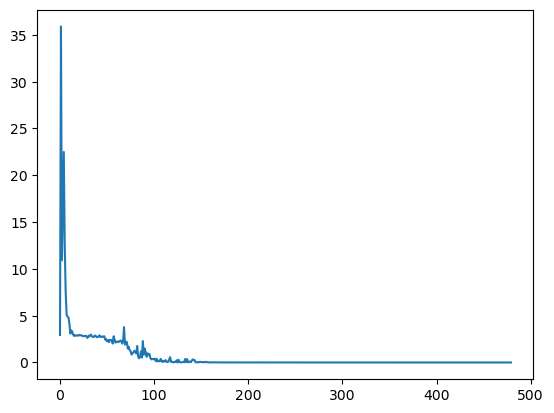

In [181]:
plt.plot(range(len(loss_values)), loss_values)

In [182]:
test_loss_values = []
test_accuracies = [] 
all_preds = []
all_labels = []
model_3.eval()

test_loss = 0
correct = 0
total = 0

with torch.no_grad():
    for data, labels in test_loader_3:
        # Move both data and labels to device
        labels = labels.to(device)
        
        # Get predictions
        outputs = model_3(data)
        loss = criterion(outputs, labels)
        
        # Accumulate loss
        test_loss += loss.item()
        
        # Get predictions
        _, predicted = torch.max(outputs.data, 1)
        
        # Save predictions and labels for metrics
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        # Calculate accuracy
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    # Calculate final metrics
    test_loss /= len(test_loader_3)
    accuracy = correct / total

    print(f'Test Loss: {test_loss:.4f}, Accuracy: {100 * accuracy:.2f}%')

# Print detailed metrics
from sklearn.metrics import classification_report, confusion_matrix
print("\nConfusion Matrix:")
print(confusion_matrix(all_labels, all_preds))
print("\nDetailed Classification Report:")
print(classification_report(all_labels, all_preds))

# Additional diagnostics
print("\nClass distribution in test set:")
from collections import Counter
print(Counter(all_labels))

# Look at some predictions
print("\nSample predictions vs actual:")
for i in range(min(10, len(all_preds))):
    print(f"Predicted: {all_preds[i]}, Actual: {all_labels[i]}")

Test Loss: 7.2470, Accuracy: 6.29%

Confusion Matrix:
[[1 0 1 2 0 0 0 0 0 0 0 1 0 0 3 0 0 0]
 [1 0 1 0 0 0 1 0 0 2 0 1 0 0 0 1 0 0]
 [0 0 2 0 0 0 3 0 0 2 0 0 1 0 0 1 1 0]
 [0 0 0 0 1 0 2 2 1 1 1 0 0 0 0 0 1 1]
 [0 0 0 1 0 0 1 0 0 0 1 0 1 0 0 0 0 0]
 [1 0 1 1 0 1 2 0 0 1 1 0 0 0 1 0 0 0]
 [0 0 2 0 0 0 1 1 1 1 0 1 1 0 0 0 1 2]
 [1 1 0 0 0 0 1 0 0 1 1 1 0 0 1 2 0 1]
 [0 1 1 1 0 0 1 0 2 0 1 0 0 1 0 2 0 1]
 [0 0 0 1 0 0 1 0 1 1 0 3 0 0 2 1 0 0]
 [2 0 0 1 0 2 0 1 2 0 0 0 0 0 0 0 1 1]
 [0 0 0 2 0 0 1 1 0 2 2 1 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 1 1 0]
 [0 0 1 2 0 0 0 1 1 1 0 0 0 0 0 1 0 0]
 [0 0 1 1 0 0 1 0 1 0 1 0 0 2 0 1 1 1]
 [1 2 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 1]
 [2 1 0 0 0 1 0 1 1 0 0 1 0 1 1 0 1 0]
 [0 0 0 1 0 2 2 0 2 2 1 0 0 0 0 0 0 0]]

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.11      0.12      0.12         8
           1       0.00      0.00      0.00         7
           2       0.20      0.20      0.20    

In [82]:
for batch_index, (data, labels) in enumerate(test_loader_3):
    print(f"Batch {batch_index}:")
    print(f"  Data shape: {data.shape}")
    print(f"  Labels shape: {labels.shape}")
    break

Batch 0:
  Data shape: torch.Size([1, 1, 247, 241])
  Labels shape: torch.Size([1])
